In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.append("FixedStrides")
from main import *
results_wolant = pd.read_csv('ip32_wolant_results.csv', sep=';')
results_fst = pd.read_csv('ip32_fst_results.csv', sep=';')
results_equal_dist = pd.read_csv('ip32_equal_dist_results.csv', sep=';')
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
# results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
# results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
# results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
# results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [2]:
def plot_prefix_distribution(prefixes):
    lengths = utils.get_lengths(prefixes)
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [3]:
# prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
node_counts_tokyo = utils.get_node_counts(prefixes_tokyo)

Read 576846 prefixes from file in 8.001420497894287 seconds


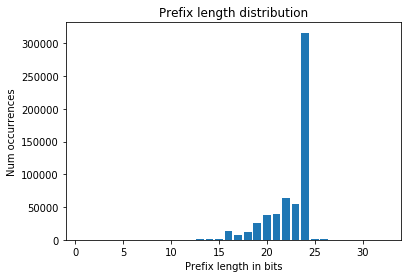

In [4]:
# plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [5]:
def get_empty_node_stats(tree_levels, strides):
    # Calculate number of empty child pointers in all nodes at each level
    # For example, if we have 100 nodes in level 1 (second level)
    # And the config for root node is 8, then it means the root node has 2^8 - 100 empty/null child pointers
    # TODO move this to utils.get_stats()
    num_empty_pointers_per_lvl = []
    percentage_empty_pointers_per_lvl = []
    total_num_pointers = 0
    for i in range(len(tree_levels) - 1):
        total_num_pointers_in_curr_lvl = tree_levels[i] * (2 ** strides[i])
        num_empty_pointers_in_curr_lvl = total_num_pointers_in_curr_lvl - tree_levels[i + 1]
        total_num_pointers += total_num_pointers_in_curr_lvl
        num_empty_pointers_per_lvl.append(num_empty_pointers_in_curr_lvl)
        percentage_empty_pointers_per_lvl.append(float(round(100 * num_empty_pointers_in_curr_lvl / total_num_pointers_in_curr_lvl, 2)))
    total_empty_pointer_percentage = float(round(100 * sum(num_empty_pointers_per_lvl) / total_num_pointers, 2))
    return num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage
        


def append_stats(row: pd.Series, nodes: list):
    strides = row['Config'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    strides = [int(x) for x in strides]
    tree_levels = row['TreeLevels'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    tree_levels = [int(x) for x in tree_levels]
    num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage = get_empty_node_stats(tree_levels, strides)
    num_empty_pointers_per_lvl = str(num_empty_pointers_per_lvl)
    percentage_empty_pointers_per_lvl = str(percentage_empty_pointers_per_lvl)
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find, num_empty_pointers_per_lvl, percentage_empty_pointers_per_lvl, total_empty_pointer_percentage])

def append_stats_to_df(df: pd.DataFrame):
    newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind', 'EmptyPointerLevels', 'PercentEmptyPointerLevels', 'TotalEmptyPointerPercentage']
    # For now assume Tokyo dataset
    newcols = df.apply(lambda row: append_stats(row, node_counts_tokyo), axis=1)
    newcols.columns = newcol_names
    return df.join(newcols)

In [6]:
results_wolant = append_stats_to_df(results_wolant)
results_fst = append_stats_to_df(results_fst)
results_equal_dist = append_stats_to_df(results_equal_dist)

In [7]:
# results_wolant = results_wolant.sort_values('RandomMatch')
# results_wolant[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_fst = results_fst.sort_values('RandomMatch')
# results_fst[['Config', 'Match', 'RandomMatch', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

# results_equal_dist = results_equal_dist.sort_values('Match')
# results_equal_dist[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

In [8]:
results_wolant = results_wolant.sort_values('RandomMatch')
results_wolant[['AverageNodeSizesLevels', 'AverageNodeSize', 'TreeHeight', 'NodeSizeToHeightRatio', 'Config', 'RandomMatch', 'Match', 'Find', 'TotalEmptyPointerPercentage', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,AverageNodeSizesLevels,AverageNodeSize,TreeHeight,NodeSizeToHeightRatio,Config,RandomMatch,Match,Find,TotalEmptyPointerPercentage,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
11,"16, 1.19512, 5.21429, 9.16867, 36.226, 21.1799...",20.90630,10,2.090630,"{8, 2, 2, 2, 2, 2, 2, 2, 2, 8}",0.552672,1.229980,25.88480,73.57,2946048,84.808467,"[83.98, 57.32, 40.71, 38.7, 41.95, 48.92, 34.2...",33.5542,"{1,41,70,166,407,945,1931,5078,17394,1559,}","[215, 94, 114, 257, 683, 1849, 2646, 2918, 68017]"
7,"16, 10.0976, 97.988, 21.1799, 32.8369, 20.4553...",21.27410,8,2.659260,"{8, 4, 4, 2, 2, 2, 2, 8}",0.783008,1.098340,27.59980,74.17,2944456,84.516228,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 97.76]",26.1560,"{1,41,166,945,1931,5078,17394,1559,}","[215, 490, 1711, 1849, 2646, 2918, 68017]"
2,"16, 10.0976, 97.988, 88.2783, 93.5729, 1.00321,",74.04960,6,12.341600,"{8, 4, 4, 4, 4, 8}",0.836576,1.857760,35.98260,92.21,2769680,121.297492,"[83.98, 74.7, 64.42, 66.42, 98.08]",22.7631,"{1,41,166,945,5078,1559,}","[215, 490, 1711, 10042, 79689]"
12,"0, 0, 0, 0, 0, 0, 0, 0.421053, 0.317073, 0.692...",7.42478,32,0.232024,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.912800,2.098690,8.67834,49.99,3551560,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",81.9532,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
10,"0, 2.07143, 17.4423, 137.596, 278.908, 0.97370...",148.51900,8,18.564800,"{4, 5, 4, 5, 6, 4, 2, 2}",1.099260,3.876260,38.91120,97.55,2972080,220.251056,"[12.5, 88.39, 68.75, 76.79, 98.74, 99.82, 88.59]",27.1227,"{1,14,52,260,1931,1559,46,21,}","[2, 396, 572, 6389, 122025, 24898, 163]"
9,"0, 1.14286, 10.0976, 97.988, 591.096, 1.00321,",211.60900,6,35.268200,"{4, 4, 4, 4, 8, 8}",2.771230,10.912000,61.91240,98.89,3311312,338.673358,"[12.5, 81.7, 74.7, 64.42, 99.36]",20.6174,"{1,14,41,166,945,1559,}","[2, 183, 490, 1711, 240361]"
6,"16, 406.829, 88.2783, 20.4553, 21.3459, 1.00321,",23.05720,6,3.842870,"{8, 8, 4, 2, 2, 8}",8.261440,0.980704,35.27510,78.39,2970800,87.575566,"[83.98, 91.0, 66.42, 14.37, 97.76]",22.8428,"{1,41,945,5078,17394,1559,}","[215, 9551, 10042, 2918, 68017]"
5,"16, 406.829, 88.2783, 93.5729, 1.00321,",75.66190,5,15.132400,"{8, 8, 4, 4, 8}",8.311330,1.584000,35.64040,92.88,2797048,121.677036,"[83.98, 91.0, 66.42, 98.08]",19.4509,"{1,41,945,5078,1559,}","[215, 9551, 10042, 79689]"
3,"16, 406.829, 21.1799, 32.8369, 20.4553, 21.345...",21.40510,7,3.057870,"{8, 8, 2, 2, 2, 2, 8}",8.391360,1.193890,26.53110,75.97,2971824,84.895772,"[83.98, 91.0, 48.92, 34.26, 14.37, 97.76]",25.3916,"{1,41,945,1931,5078,17394,1559,}","[215, 9551, 1849, 2646, 2918, 68017]"
8,"16, 406.829, 592.751,",584.44400,3,194.815000,"{8, 8, 16}",9.360800,10.740800,60.51320,90.83,2358400,3.271119,"[83.98, 91.0]",14.5194,"{1,41,945,}","[215, 9551]"


In [9]:
results_fst = results_fst.sort_values('RandomMatch')
results_fst[['AverageNodeSizesLevels', 'AverageNodeSize', 'TreeHeight', 'NodeSizeToHeightRatio', 'Config', 'RandomMatch', 'Match', 'Find', 'TotalEmptyPointerPercentage', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,AverageNodeSizesLevels,AverageNodeSize,TreeHeight,NodeSizeToHeightRatio,Config,RandomMatch,Match,Find,TotalEmptyPointerPercentage,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
11,"16, 10.0976, 97.988, 21.1799, 32.8369, 20.4553...",9.23752,13,0.710578,"{8, 4, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 3}",0.675904,1.429380,27.47920,56.64,3383536,90.109119,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",39.7401,"{1,41,166,945,1931,5078,17394,33779,1559,1017,...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
10,"16, 10.0976, 97.988, 21.1799, 32.8369, 20.4553...",9.39045,12,0.782538,"{8, 4, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",0.696576,1.268510,27.03960,57.67,3379696,90.136753,"[83.98, 74.7, 64.42, 48.92, 34.26, 14.37, 2.9,...",36.8288,"{1,41,166,945,1931,5078,17394,33779,1559,442,6...","[215, 490, 1711, 1849, 2646, 2918, 1009, 65999..."
12,"0, 0, 0, 0, 0, 0, 0, 0.421053, 0.317073, 0.692...",7.42478,32,0.232024,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.809376,2.119170,8.69766,49.99,3551560,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",86.2682,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
0,"0, 2, 10.0976, 97.988, 21.1799, 32.8369, 20.45...",20.06980,15,1.337990,"{3, 5, 4, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2}",0.828384,1.409090,29.95070,74.17,2983040,84.788536,"[0.0, 83.98, 74.7, 64.42, 48.92, 34.26, 14.37,...",46.7061,"{1,8,41,166,945,1931,5078,17394,1559,1017,442,...","[0, 215, 490, 1711, 1849, 2646, 2918, 68017, 2..."
9,"430, 97.988, 21.1799, 32.8369, 20.4553, 3.1736...",9.39672,11,0.854247,"{12, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",1.630180,1.007870,27.32230,58.60,3392064,90.168056,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",34.1563,"{1,166,945,1931,5078,17394,33779,1559,442,63,30,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
8,"430, 97.988, 21.1799, 32.8369, 20.4553, 3.1736...",9.40392,10,0.940392,"{12, 4, 2, 2, 2, 1, 1, 2, 2, 4}",1.703870,0.943200,27.33770,58.81,3394176,90.201315,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",31.6418,"{1,166,945,1931,5078,17394,33779,1559,442,46,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 57..."
7,"430, 97.988, 21.1799, 32.8369, 20.4553, 3.1736...",9.46953,9,1.052170,"{12, 4, 2, 2, 2, 1, 1, 3, 5}",1.710500,1.011200,27.29690,60.29,3408608,90.352937,"[95.95, 64.42, 48.92, 34.26, 14.37, 2.9, 97.69...",29.0969,"{1,166,945,1931,5078,17394,33779,1559,63,}","[3930, 1711, 1849, 2646, 2918, 1009, 65999, 12..."
6,"936, 89.1192, 57.5848, 20.4553, 3.17362, 9.357...",9.70239,8,1.212800,"{13, 4, 3, 2, 1, 1, 3, 5}",3.167550,0.998112,32.10160,62.38,3415496,91.418692,"[96.83, 68.27, 51.91, 14.37, 2.9, 97.69, 99.49]",27.4073,"{1,260,1320,5078,17394,33779,1559,63,}","[7932, 2840, 5482, 2918, 1009, 65999, 12409]"
4,"24107, 57.5848, 20.4553, 3.17362, 9.35756, 1.0...",9.75539,6,1.625900,"{17, 3, 2, 1, 1, 8}",45.969800,0.836960,36.32520,77.63,3837824,93.501291,"[98.99, 51.91, 14.37, 2.9, 97.69]",23.7607,"{1,1320,5078,17394,33779,1559,}","[129752, 5482, 2918, 1009, 65999]"
5,"24107, 57.5848, 20.4553, 3.17362, 9.35756, 0.9...",9.74501,7,1.392140,"{17, 3, 2, 1, 1, 3, 5}",46.304200,0.972768,36.14440,78.61,3888256,93.986481,"[98.99, 51.91, 14.37, 2.9, 97.69, 99.49]",25.9837,"{1,1320,5078,17394,33779,1559,63,}","[129752, 5482, 2918, 1009, 65999, 12409]"


In [10]:
results_equal_dist = results_equal_dist.sort_values('RandomMatch')
results_equal_dist[['AverageNodeSizesLevels', 'AverageNodeSize', 'TreeHeight', 'NodeSizeToHeightRatio', 'Config', 'RandomMatch', 'Match', 'Find', 'TotalEmptyPointerPercentage', 'TreeMemoryUniqueOnly', 'Percent', 'PercentEmptyPointerLevels', 'Build', 'TreeLevels', 'EmptyPointerLevels']]

,AverageNodeSizesLevels,AverageNodeSize,TreeHeight,NodeSizeToHeightRatio,Config,RandomMatch,Match,Find,TotalEmptyPointerPercentage,TreeMemoryUniqueOnly,Percent,PercentEmptyPointerLevels,Build,TreeLevels,EmptyPointerLevels
4,"0, 0, 0, 0, 0, 0, 0, 0.421053, 0.317073, 0.692...",7.42478,32,0.232024,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.729696,2.847010,9.02506,49.99,3551560,100.000000,"[0.0, 0.0, 0.0, 12.5, 10.71, 36.0, 40.62, 46.0...",91.3362,"{1,2,4,8,14,25,32,38,41,52,70,107,166,260,407,...","[0, 0, 0, 2, 3, 18, 26, 35, 30, 34, 33, 48, 72..."
3,"100119, 7.89307, 6.94362, 3.17362, 9.35756, 1....",8.60990,6,1.434980,"{20, 1, 1, 1, 1, 8}",195.233000,0.973440,182.14100,94.32,7561408,136.816479,"[99.52, 9.54, 5.33, 2.9, 97.69]",25.2722,"{1,5078,9187,17394,33779,1559,}","[1043498, 969, 980, 1009, 65999]"
2,"100119, 20.4553, 3.17362, 9.35756, 1.00321,",9.97814,5,1.995630,"{20, 2, 1, 1, 8}",198.750000,1.258210,182.38900,95.06,7455000,132.745921,"[99.52, 14.37, 2.9, 97.69]",23.6909,"{1,5078,17394,33779,1559,}","[1043498, 2918, 1009, 65999]"
1,"140200, 12.9523, 9.35756, 1.00321,",12.95530,4,3.238820,"{21, 2, 1, 8}",288.229000,0.887904,321.21900,97.98,11469576,185.513142,"[99.56, 8.08, 97.69]",22.6240,"{1,9187,33779,1559,}","[2087965, 2969, 65999]"
0,"203991, 3.17362, 9.40386,",11.27220,3,3.757420,"{22, 1, 9}",440.395000,30.551400,710.31200,98.79,19633256,275.912299,"[99.59, 2.9]",18.7700,"{1,17394,33779,}","[4176910, 1009]"


In [11]:
results_equal_dist.columns
# newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
# newcols_au = results_au_32bit.apply(lambda row: append_stats(row, nodes_au), axis=1)
# newcols_tokyo = results_tokyo.apply(lambda row: append_stats(row, nodes_tokyo), axis=1)
# newcols_au.columns = newcol_names
# newcols_tokyo.columns = newcol_names
# results_au_32bit = results_au_32bit.join(newcols_au)
# results_tokyo = results_tokyo.join(newcols_tokyo)
# results_au_32bit = results_au_32bit.sort_values('MatchAndFind')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_tokyo = results_tokyo.sort_values('TreeMemoryUniqueOnly')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]
# results_au_32bit = results_au_32bit.sort_values('TreeMemoryUniqueOnly')
# results_au_32bit[['Config', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'TreeLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_tokyo = results_tokyo.sort_values('Match')
# results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit = results_tokyo.sort_values('Find')
# results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Match'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Find'])
# results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Build'])
# results_tokyo['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['ChildrenMemory'].corr(results_au_32bit['Cost'])
# results_au_32bit['Match'].corr(results_au_32bit['Cost'])
# results_tokyo['Match'].corr(results_au_32bit['Cost'])

Index(['deviceId', 'deviceName', 'Dictionary', 'Load', 'Count', 'Sort',
       'Config', 'Reshape', 'Build', 'TreeMemory', 'TreeLevels', 'Depth',
       'TreeMemoryUniqueOnly', 'ChildrenMemory', 'ChildrenCountsMemory',
       'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory',
       'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory',
       'ContainerStartsMemory', 'ContainerLengthsMemory',
       'AverageNodeSizesLevels', 'AverageNodeSize', 'TreeHeight',
       'NodeSizeToHeightRatio', 'Find', 'Match', 'RandomCount', 'RandomMatch',
       'RandomSort', 'RandomSortedMatch', 'HitRate', 'Unnamed: 35', 'Cost',
       'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind',
       'EmptyPointerLevels', 'PercentEmptyPointerLevels',
       'TotalEmptyPointerPercentage'],
      dtype='object')